# Kinetic analysis of strategy enabling anaerobic production of PHB

In this script, we have performed the ECM analyses for the thermodynamic investigation of the NOG+EMP pathway, also demonstrating how the analysis of other pathways and metabolic engineering strategies could be analyzed by other researchers with the custom-made functions we have developed in this study.

In [1]:
from equilibrator_api import Q_ #for creating quantity variables
import equilibrator_custom_functions as eq #custom functions created during analysis
import numpy as np #numerical package
import math
import matplotlib.pyplot as plt #plotting package
import matplotlib.ticker as mtick

Fragments already downloaded
Fragments already downloaded


# Input Files and their formats

The script's input is based on the two custom __input csv files__, which are:

   __The compound file__, with metabolite names, IDs and bounds. It is currently name "metabolite_reference_table"
   
   This file uses a custom csv file format, which contains information of multiple metabolites, to create a dictionary which will be used for the eQuilibrator API for high throughput analysis. This dictionary allows for writing reactions in a simpler way (with acronyms), and customizing the ranges of metabolites according to data. The columns contain the following elements:

| Metabolite Acronym        | keggID                          | Lower Bound (M)             | Upper Bound (M)               |
|------------------|----------------------------------|----------------------|------------------------|
|Custom-defined name for metabolite| Kegg ID to identify metabolite (necessary to use specific kegg ID) | Custom-defined minimal concentration (in M)| Custom-defined maximal concentration (in M) |

Notice that the columns do not need to be mantained in order to be recognized in the script. More usefull information can be added to the other columns, as the script will ignore the information stored in these.

   __The pathway file__, with reaction names, formulae, fluxes, and, in the case of ECM, enzyme parameters (which will be read by other functions below). Being pathway specific, there are many files referenced in this script. The columns contain the follow basic setup:
   
| Reaction Formula        | Relative Flux                          | Reaction Name  |     Standard dG (kJ/mol)        | kcrf(1/s) | MWe(Da)        | kM(mM) |
|------------------|----------------------------------|----------------------|------------------------|-----------------|-------|-----|
|Using the acronyms defined in the compound file: S1 + S2 <=> P1 + P2| The relative stoichiometric coefficient of the reaction in the pathway | Customizable name to identify the reaction in graphs, for example | __(Optional)__ Standard Gibs Free Energy of Reaction in kJ/mol. These are custom values that can replace the values obtained from the eQuilibrator packages|__(Only needed for ECM)__ Forward catalytic rate of reaction's enzyme in 1/s (mind the direction of the reaction) |__(Only needed for ECM)__ Enzyme molecular weight, equivalent to Daltons |__(Only needed for ECM)__ Michaelis costants of each substrate and product (except water) in milimolar, with format example 'S1: 0.1 S2:0.02 P1:3 P2:0.3' | 

# Setting Intracellular Conditions

Below we set the intracellular conditions in *E. coli*, i.e the pH, ionic strengh, temperature and pMg (which have an effect on the thermodynamics of reactions). Note that metabolite concentration bounds are also organism specific, but are defined in the compound file.

In the cell bellow the name of the compound csv file is defined __("metabolite_reference_table")__. With the function __eq.obtain_compound_settings( string: compound_file_name )__, we construct a __CompoundSettings__ object containing data structures for idetifying compounds and setting their maximal and minimal concentrations for the model)

With __eq.change_bounds__ , one can create a new CompoundSettings object with specific changes in the metabolite concentration bounds.

The __eq.fix_concentrations__ function can also be used when the concentration needs to fixed at a specific concentration

In [2]:
#E. coli physiological conditions as a dictionary
E_coli_con = {
            "p_h": str(Q_("7.5")),
            "p_mg": str(Q_(10)),
            "ionic_strength": str(Q_('200 mM')),
            "temperature": str(Q_(37+273.15,"K")),
            "kcat_source": "fwd",
}

#Generating Compound Settings with the default eQuilibrator bounds
cs_default_bounds = eq.obtain_compound_settings("metabolite_reference_table_custom", custom_bounds = True)
#Lowering the CoA lower concentration bound to 1 uM, 'freeing' CoA concentration for optimization at lower levels
#cs_free_CoA = eq.change_bounds(cs_default_bounds, [('CoA',Q_(1e-6,'M'), Q_(1e-3,'M'))])
#Reducing AcCoA upper bound in order to represent conditions of lower size of CoA moiety of approximately 1 mM
#cs_reduced_AcCoA_CoA = eq.change_bounds(cs_free_CoA, [('AcCoA',Q_(1e-6,'M'), Q_(1e-3,'M'))])
#NAD and NADH are released to bounds of 0.1 mM and 1 mM
#cs_free_NAD = eq.change_bounds(cs_free_CoA, [('NAD',Q_(1e-4,'M'),Q_(1e-3,'M')),('NADH',Q_(1e-4,'M'),Q_(1e-3,'M'))])

# Calculating absolute flux of reactions

For ECM, an important step is the calculation of absolute fluxes of reactions, which will affect the enzyme concentrations/masses calculated. Note that with the same compound settings and kinetic parameters, __(enzyme cost)/flux is a constant__, meaning that changing absolute flux won't affect the relative levels of enzymes (though it would change total concentrations).

In this case the ATP consumption rate for cell maintenance (divided by the pathway's ATP yield of 2) is used to defined the __minimum pathway flux__, in a scenario in which cells are not growing, only surviving and accumulating PHB.

In [3]:
#CDW__Cmol_ratio = Q_(23.2,'g/mol')

Volume_per_CDW = Q_(1.9, 'ul/mg').to('L/g')
Y_ATP = Q_(2,'mol/mol') #mol ATP/mol pathway net reaction
mATP_perCDW = Q_((3.2/1000/0.0019/3600)*3600*1.9e-3,'mol/gram/hour')

flux_ATP = mATP_perCDW/Y_ATP/Volume_per_CDW

flux_ATP = flux_ATP.to('M/s')

print(flux_ATP)

0.00023391812865497077 molar / second


# Checking enzyme parameters according to Haldane Relationship

The kinetic parameters of the all enzymes involved in the reaction can be readily verified by __eq.check_parameters__. For all the enzymes whose parameters yield a Haldane Relationship outside of the % tolerance for K<sub>EQ</sub>, a message will be printed. Tolerance is defined to 0% by default.

In [4]:
#(Keq,_) = eq.check_parameters("ED",cs_default_bounds,E_coli_con,flux_ATP, tolerance = 0.05)

# Enzyme Cost Minimization (ECM) analysis

The ECM analysis can be performed with the function __eq.ECM_analysis__, using as arguments the name of the pathway csv file, the CompoundSettings object, the physiological context dictionary and the caculated absolute flux of the pathway. The function returns a model object which will be an input in the __eq.myECM__ function, where an initial log-concentration vector needs to be provided. The MDF solution is a suitable set of concentrations to use. The number of iterations can also be determined. The function returns the log-concentration vector of the solution.

Here we perform ECM analysis for CoA moiety pools of 1 mM and 10 mM:

In [5]:
model_1mM = eq.ECM_analysis("EMP_ecm",cs_default_bounds,E_coli_con,flux_ATP)
#model_1mM = eq.ECM_analysis("ED",cs_reduced_AcCoA_CoA,E_coli_con,flux_ATP)
#model_10mM = eq.ECM_analysis("ED",cs_free_CoA,E_coli_con,flux_ATP)

#Calculate MDF and obtain the log([metabolites]) of the MDF solution.
lnC_MDF_1mM = model_1mM.MDF()
#lnC_MDF_10mM = model_10mM.MDF()

lnC_ECM_1mM = eq.myECM(model_1mM.ecf,'SLSQP',ln_conc0 = lnC_MDF_1mM,n_iter=1000)
#lnC_ECM_10mM = eq.myECM(model_10mM.ecf,'SLSQP',ln_conc0 = lnC_MDF_10mM,n_iter=1000)

C:\Programs\Anaconda3\envs\MarcosPaper\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


## Total enzyme mass concentration

With the resulting log-concentration vector, total enzyme mass concentration can be determined with the function __eq.total_enzyme_volume__ (with inputs of model object and log-concentration vector). The result in gram/liter was also normalized to cell dry weight by dividing it with the volume per CDW value.

In [6]:
print((eq.total_enzyme_volume(model_1mM,lnC_ECM_1mM)*Volume_per_CDW,eq.total_enzyme_volume(model_1mM,lnC_ECM_1mM)))
#print((eq.total_enzyme_volume(model_10mM,lnC_ECM_10mM)*Volume_per_CDW,eq.total_enzyme_volume(model_10mM,lnC_ECM_10mM)))

(<Quantity(0.0410649109, 'dimensionless')>, <Quantity(21.613111, 'gram / liter')>)


## Molar concentrations of enzymes

Molar concentrations of each enzymes can be obtained in the followig manner:

In [7]:
enz_conc = dict(zip(model_1mM.reaction_ids,list(model_1mM.ecf.ECF(lnC_ECM_1mM).flat)))
#print(enz_conc)
#type(enz_conc)

import csv
with open('molarEMP.csv', 'w', newline='') as csv_file:  
    writer = csv.writer(csv_file,delimiter=',')
    for key, value in enz_conc.items():
      writer.writerow([key, value])

## Mass concentrations of enzymes

With the __enzyme_cost_distribution__ function, we can obtain an ordered dictionary of individual enzyme mass concentrations (in grams/liter) and individual percentages of total enzyme mass concentration.

In [8]:
(totals_1mM,percents_1mM) = eq.enzyme_cost_distribution(model_1mM,lnC_ECM_1mM)
#(totals_10mM,percents_10mM) = eq.enzyme_cost_distribution(model_10mM,lnC_ECM_10mM)

#print(totals_1mM)
#print(totals_10mM)

#Example of how to access specific value:
#percents_1mM['PhaB']

totalThioAAR = (percents_1mM['Thio']*100)+(percents_1mM['AAR']*100)
print(totalThioAAR)

import csv
with open('massEMP.csv', 'w', newline='') as csv_file:  
    writer = csv.writer(csv_file,delimiter=',')
    for key, value in totals_1mM.items():
      writer.writerow([key, value])

27.118989986850025


## Metabolite concentrations

Metabolite concentrations (in M) can be verified in the following manner:

In [9]:
conc_dict_1mM = dict(zip(model_1mM.compound_ids, np.exp(lnC_ECM_1mM).flatten()))
#conc_dict_10mM = dict(zip(model_10mM.compound_ids, np.exp(lnC_ECM_10mM).flatten()))

print(conc_dict_1mM)
#print(conc_dict_10mM)

#Example of how to access specific value:
#conc_dict_1mM['NADH']

{'ATP': 0.00041900000000000005, 'ADP': 0.0009866217058149885, 'NAD': 0.0018571888702584621, 'Pi': 0.02015844863238147, 'NADH': 0.000452, 'CoA': 0.0002710000000000002, 'AcCoA': 0.00648277933662262, 'PYR': 0.0014188903128763836, 'FOR': 4.999999999999999e-06, 'Gluc': 0.0003658520251926583, 'PEP': 0.00024574386596791547, 'G3P': 0.00014370727884100074, 'ACDH': 3.259548676399972e-05, 'DHAP': 0.0014660082402557608, 'P3G': 0.004226162441553775, 'AcAcCoA': 2.4782457973397774e-06, 'G6P': 0.00405205774928735, 'BPG': 4.999999999999999e-06, 'P2G': 0.00032373253827639505, 'ETOH': 5.000000000000211e-06, 'FBP': 0.007669519916448523, 'HBCoA': 4.999999999999999e-06, 'F6P': 0.000685}


## Plotting enzyme demand distribution:

We use the function __eq.ECM_plot__ for plotting these graphs. The main difference from the original eQuilibrator plotting function is that in our case the measured concentrations of metabolites are not mandatory for plotting the graph.

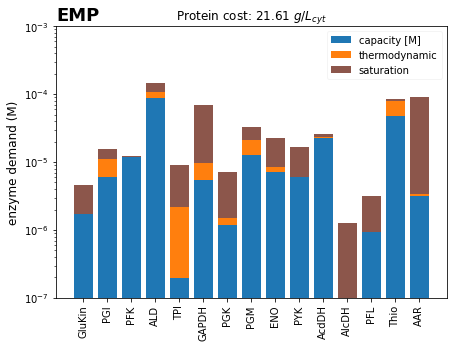

In [10]:
fig1 = plt.figure(figsize=(7, 5))

ECM_1mM_mass_conc= round(eq.total_enzyme_volume(model_1mM,lnC_ECM_1mM).m_as('g/L'),2)
ax_1mM = fig1.add_subplot(1, 1, 1)
ax_1mM.set_title("Protein cost: " + str(ECM_1mM_mass_conc) + ' $g/L_{cyt}$')
ax_1mM.legend(loc="center left", bbox_to_anchor=(1, 0.5));
eq.ECM_plot(model_1mM,lnC_ECM_1mM,ax_1mM)
ax_1mM.annotate("EMP", xy=(0, 1.02), xycoords="axes fraction",fontsize = 18, fontweight = 'demibold')
plt.ylim( (pow(10,-7),pow(10,-3)) )
fig1.savefig('ECM_EMP.tiff', dpi = 150)

## Enzyme cost partition values

The partions of enzyme cost can be obtained by the __model.ecf.GetEnzymeCostPartitions__ function, and returns a 2D array with basic capacity concentrations (blue bars) on 1st column, fold increase in demand due to thermodynamics (orange bar) in the 2nd column and fold increase in demand due to saturation (brown bar) in 3rd. The 4th column is related to regulation fold change, which was not analyzed in our study.

In [11]:
print(model_1mM.ecf.GetEnzymeCostPartitions(lnC_ECM_1mM))
np.savetxt("costsEMP.csv", model_1mM.ecf.GetEnzymeCostPartitions(lnC_ECM_1mM), delimiter=',')

[[1.72652546e-06 1.00527958e+00 2.67864355e+00 4.00000000e+00]
 [6.01322160e-06 1.86770257e+00 1.37830249e+00 4.00000000e+00]
 [1.16940938e-05 1.00668845e+00 1.03798425e+00 4.00000000e+00]
 [8.82909824e-05 1.20426314e+00 1.35959297e+00 4.00000000e+00]
 [1.94752093e-07 1.13006945e+01 4.13251211e+00 4.00000000e+00]
 [5.40468151e-06 1.77506676e+00 7.09781275e+00 4.00000000e+00]
 [1.19695370e-06 1.23461017e+00 4.82648482e+00 4.00000000e+00]
 [1.24871550e-05 1.68950011e+00 1.57475318e+00 4.00000000e+00]
 [7.16641905e-06 1.17092398e+00 2.65682164e+00 4.00000000e+00]
 [6.06725149e-06 1.00022954e+00 2.78688520e+00 4.00000000e+00]
 [2.23337514e-05 1.04671600e+00 1.12192212e+00 4.00000000e+00]
 [5.48821622e-09 1.00088146e+00 2.30045670e+02 4.00000000e+00]
 [9.20225306e-07 1.00001993e+00 3.40346408e+00 4.00000000e+00]
 [4.68356133e-05 1.71275787e+00 1.05132105e+00 4.00000000e+00]
 [3.20324995e-06 1.04143474e+00 2.72685461e+01 4.00000000e+00]]


## Optmizing NADH/NAD

We also analyze the ECM when the NADH/NAD ratio is free to be optimized:

# Parameter sweep of K<sub>M</sub> values of acetoacetyl-CoA reductase

Due to a significant portion of the enzyme cost being of acetoacetyl-CoA reductase (PhaB), we have performed a K<sub>M</sub> parameter sweep for the substrates and products of the enzyme, with the function __eq.ECM_kM_sweep__:

# Substrate Channeling in ECM

We perform the same ECM analysis with implemented substrate channeling of ketothiolase and acetoacetyl-CoA reductase:

We do the same to the case in which substrate channeling is implemented between the three enzymes from *phaCAB*: